In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import cmcrameri.cm


In [ ]:
ibge = gpd.read_file(r'Data\IBGE\BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
ds_knn = xr.open_dataset(r'Data\knn_cerrado3.nc')
ds_knn.rio.write_crs(shp_cerrado.crs, inplace=True)
regions = gpd.read_file(r'Data\regions1.geojson')
gdf_knn = gpd.read_file('Data\gdf_knn_bet.geojson')
palette = sns.color_palette('cmc.batlow', 3)

# EDA

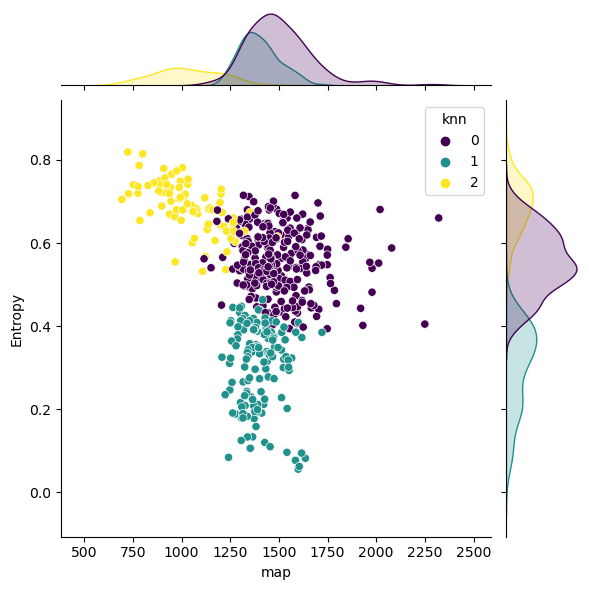

In [3]:
sns.jointplot(data=gdf_knn, x='map', y='Entropy', hue='knn', palette='viridis')
#pair plot with metrics
metrics_plot = ['map', 'dsl',  'dry_precip', 'wet_precip', 'msi', 'Entropy', 'knn']

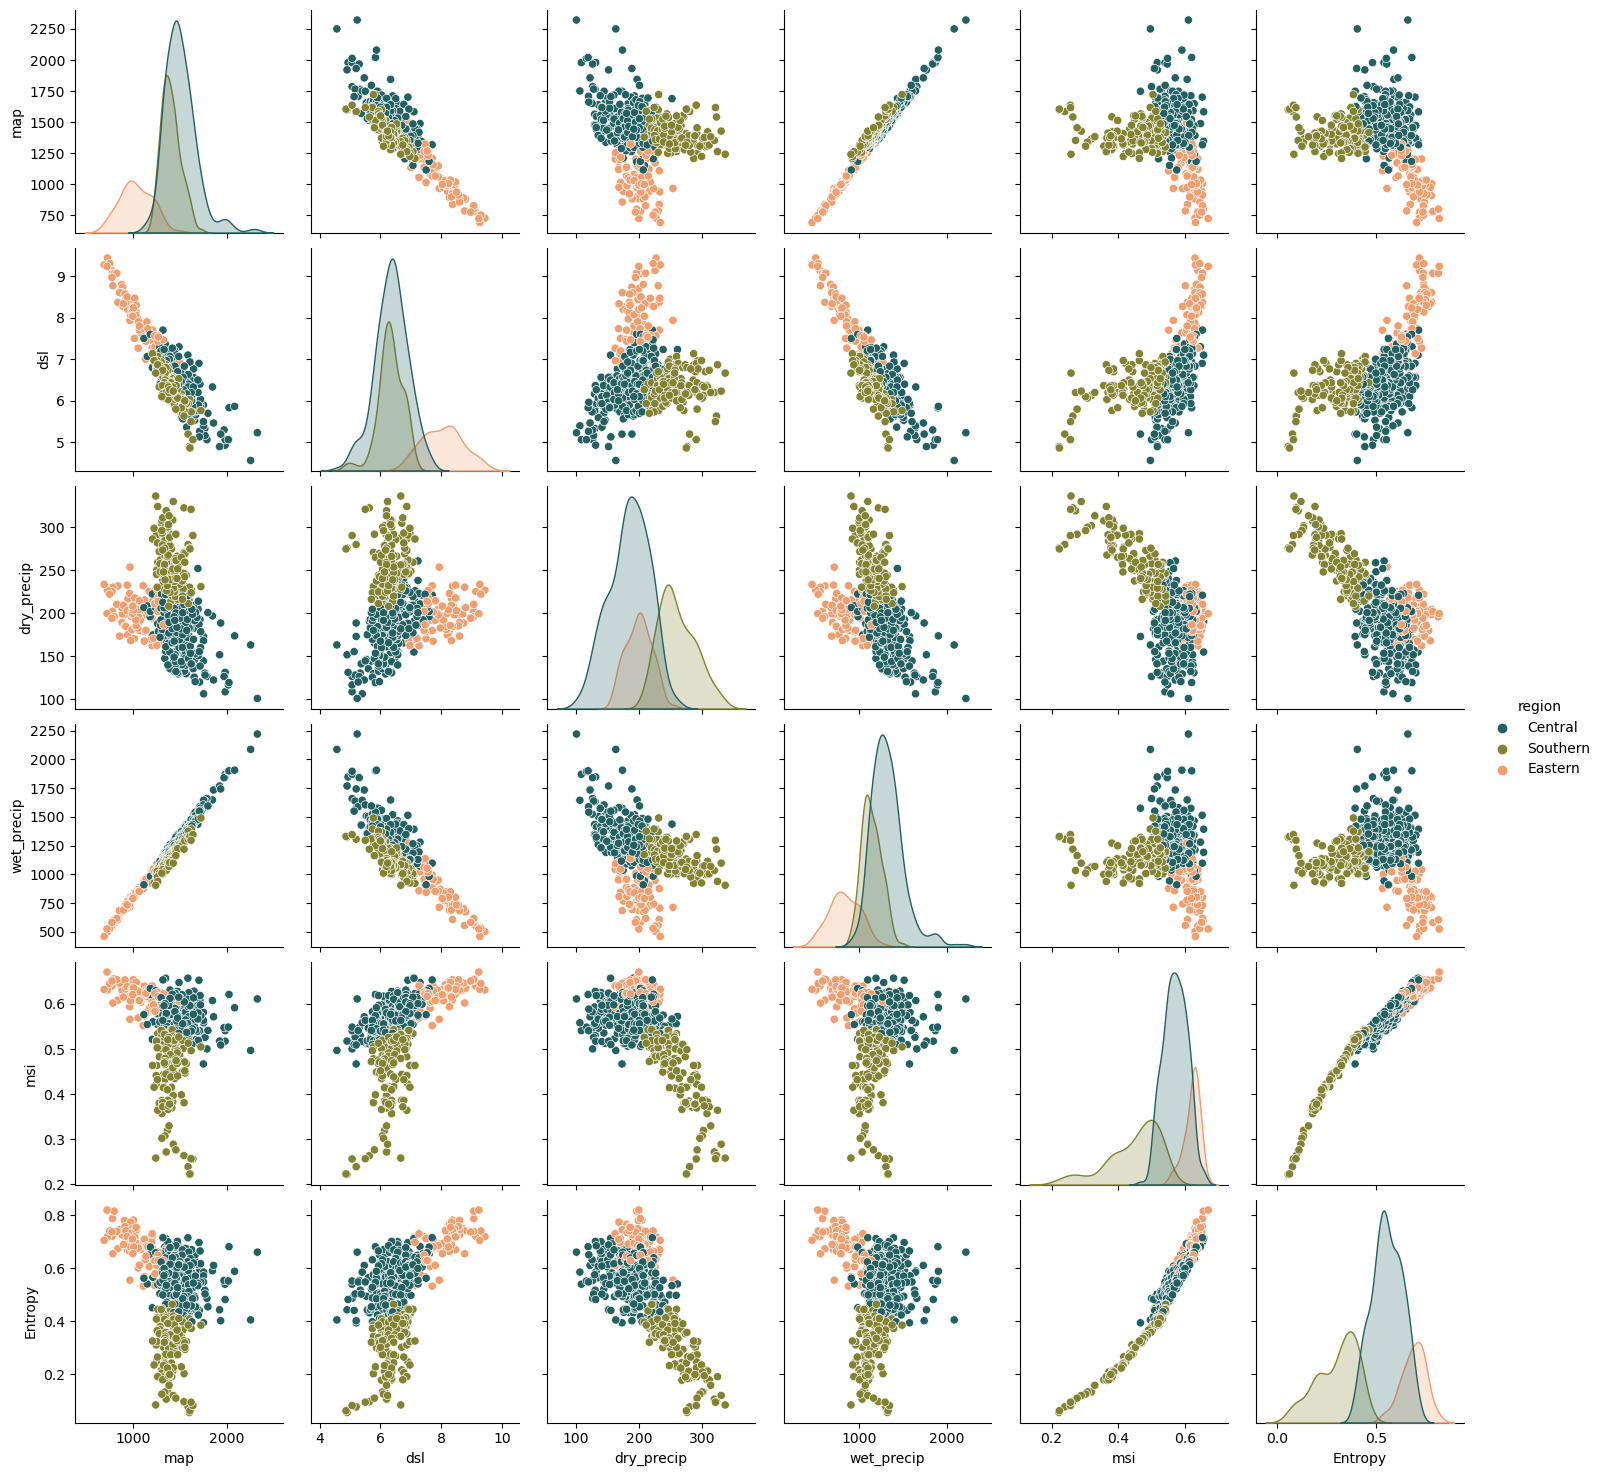

In [6]:
metrics_plot = ['map', 'dsl',  'dry_precip', 'wet_precip', 'msi', 'Entropy','region']

sns.pairplot(gdf_knn[metrics_plot], hue='region', palette=palette,hue_order=['Central', 'Southern', 'Eastern'])

In [5]:
df_cerrado = pd.read_pickle('Data\df_cerrado_bet.pkl')
df_stat_month= df_cerrado.groupby(['Code', df_cerrado.Date.dt.month]).mean().reset_index()
df_stat_month = df_stat_month.merge(gdf_knn[['Code', 'knn']], on='Code', how='left')
#boxplot of df_cerrado
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(hue='knn', y='Total',x='Date', data=df_stat_month,ax=ax)

C:\Users\luisg\AppData\Local\Temp\ipykernel_21980\2558842960.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_stat_month= df_cerrado.groupby(['Code', df_cerrado.Date.dt.month]).mean().reset_index()


# mapbiomas LCU

In [2]:
df0 = pd.read_csv("Data\Mapbiomas\cluster0_area.csv", usecols=['class', 'area' ,'class_name'])
df1 = pd.read_csv("Data\Mapbiomas\cluster1_area.csv", usecols=['class', 'area' ,'class_name'])
df2 = pd.read_csv("Data\Mapbiomas\cluster2_area.csv", usecols=['class', 'area' ,'class_name'])

In [3]:
df_all = df0.merge(df1[['area','class']], on='class', suffixes=('_0', '_1'), how='outer')
df_all = df_all.merge(df2[['area','class']], on='class', how='outer')
#change NAN to 0
df_all = df_all.fillna(0)
df_all['area_all'] = df_all['area_0'] + df_all['area_1'] + df_all['area']

In [4]:
total_area = df0['area'].sum() + df1['area'].sum() + df2['area'].sum()
#print the % of each df area from the total
print('cluster 0: ', df0['area'].sum()/total_area*100)
print('cluster 1: ', df1['area'].sum()/total_area*100)
print('cluster 2: ', df2['area'].sum()/total_area*100)

cluster 0:  62.36826520774989
cluster 1:  11.688643454845153
cluster 2:  25.94309133740495


In [5]:
#calculate the percentage of each class
df0['0_area_%'] = df0['area']/df0['area'].sum()*100
df0 = df0[['class', '0_area_%', 'class_name']]
df1['1_area_%'] = df1['area']/df1['area'].sum()*100
df1 = df1[['class', '1_area_%']]
df2['2_area_%'] = df2['area']/df2['area'].sum()*100
df2 = df2[['class', '2_area_%']]
df_all['all_area_%'] = df_all['area_all']/df_all['area_all'].sum()*100

In [11]:
#merge all dfs
df = df0.merge(df1, on='class', how='outer')
df = df.merge(df2, on='class' , how='outer')
df = df.merge(df_all[['class', 'all_area_%']], on='class', how='outer')
#df = df.merge(df2, on='class', how='left')
df = df[['class', 'class_name',  '0_area_%', '1_area_%','2_area_%', 'all_area_%']].set_index('class_name')

In [14]:
#define our classes
forest = ['Forest Formation', 'Forest Plantation']
woody_savanna = ['Savanna Formation']
grassland = ['Grassland (Pastizal, Formación Herbácea)']
wetland = ['Wetland', 'Magrove']
humam = ['Pasture','Mining', 'Aquaculture', 'Sugar Cane','Mosaic of Agriculture and Pasture','Urban Infrastructure', 'Soy Beans', 'Rice', 'Mosaic of Crops', 'Coffe', 'Citrus',
       'Other Perennial Crops']
others = ['Non Observed','Beach and Dune', 'Other Non Vegetated Area', 'Rocky outcrop', 'Salt flat', 'River, Lake and Ocean']

#sum rows that are in each list
df.loc['Others'] = df.loc[others].sum()
df.loc['Forest'] = df.loc[forest].sum()
df.loc['Woody Savanna'] = df.loc[woody_savanna].sum()
df.loc['Grassland'] = df.loc[grassland].sum()
df.loc['Wetlands'] = df.loc[wetland].sum()
df.loc['Humam Influence'] = df.loc[humam].sum()
df.rename(columns={'0_area_%': 'Central', '1_area_%': 'Southern', '2_area_%': 'Eastern', 'all_area_%' : 'All'}, inplace=True)

In [8]:
regs = df.columns[-3:].to_list() #['Center', 'South', 'East']
#get only the last 6 rows
df_classes = df.iloc[-6:]
#df_classes.to_csv('Data\Mapbiomas\LUC_areas.csv')

In [9]:
df_classes

,class,Central,Southern,Eastern,All
class_name,,,,,
Others,142.0,1.638203,1.323832,1.568510,1.583377
Forest,12.0,19.762690,22.450396,9.731334,17.474403
Woody Savanna,4.0,36.029098,12.075559,60.396678,39.550958
Grassland,12.0,6.173916,0.572360,9.310791,6.332973
Wetlands,16.0,4.140043,2.642327,0.605928,3.048122
Humam Influence,402.0,32.256049,60.935526,18.386758,32.010168


Text(0, 0.5, 'Area (%)')

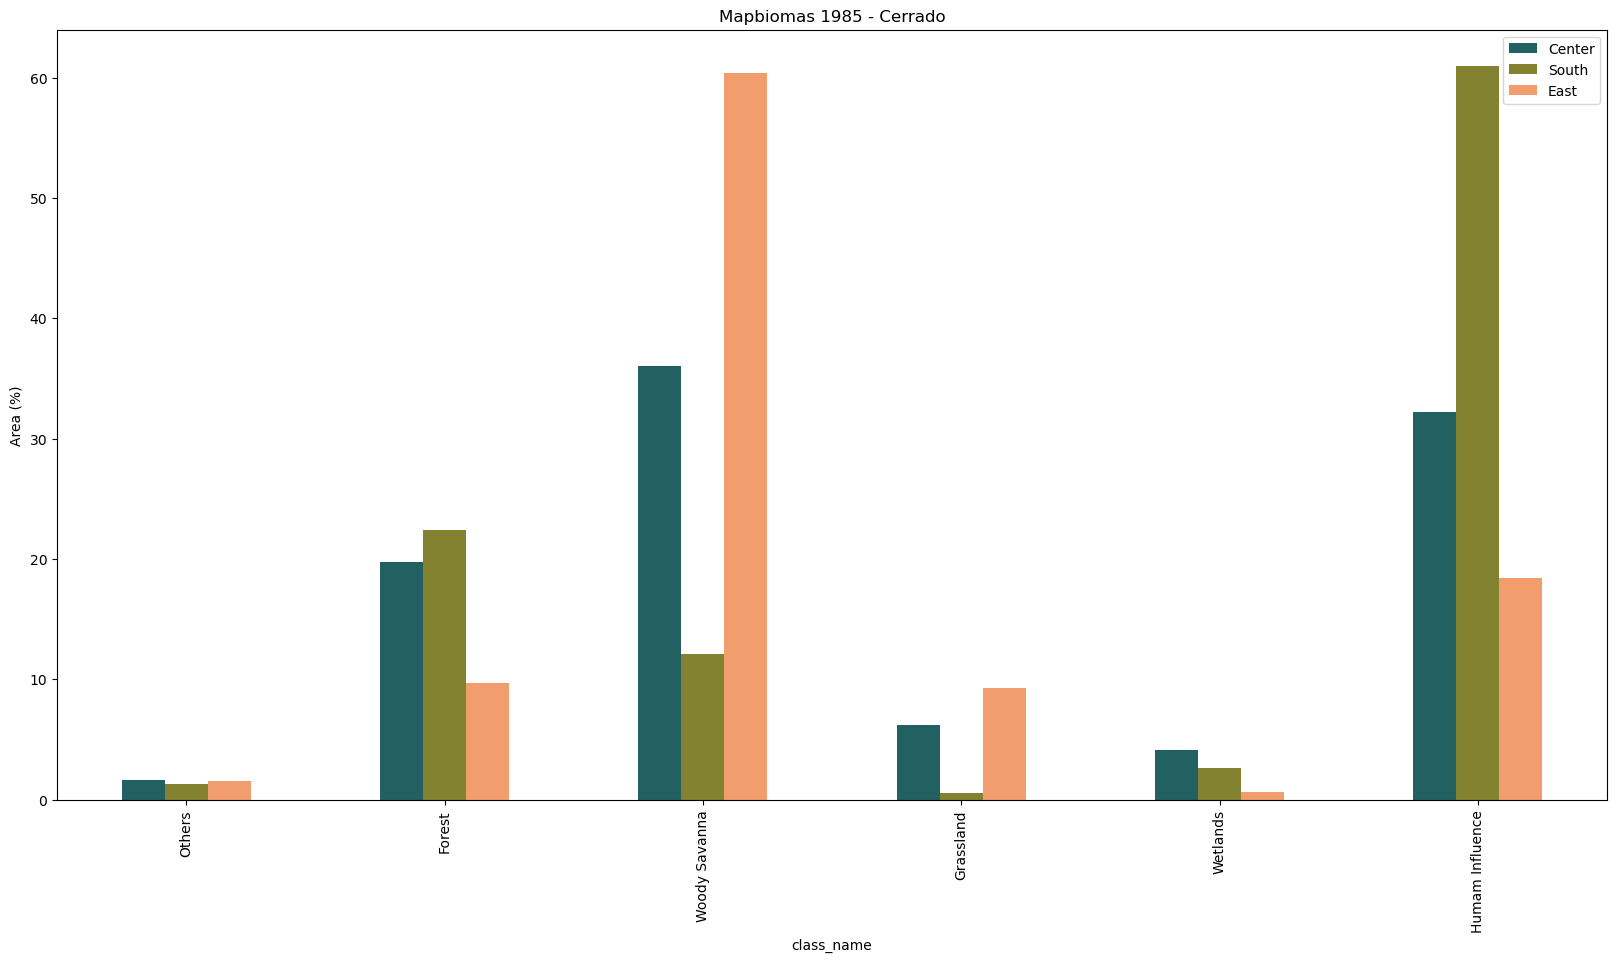

In [ ]:
#bar plot of all classes for each cluster
df_classes[regs].plot(kind='bar', figsize=(20,10), color=palette)
plt.grid(False)

plt.title('Mapbiomas 1985 - Cerrado')
plt.ylabel('Area (%)')

<AxesSubplot: xlabel='cluster', ylabel='Count'>

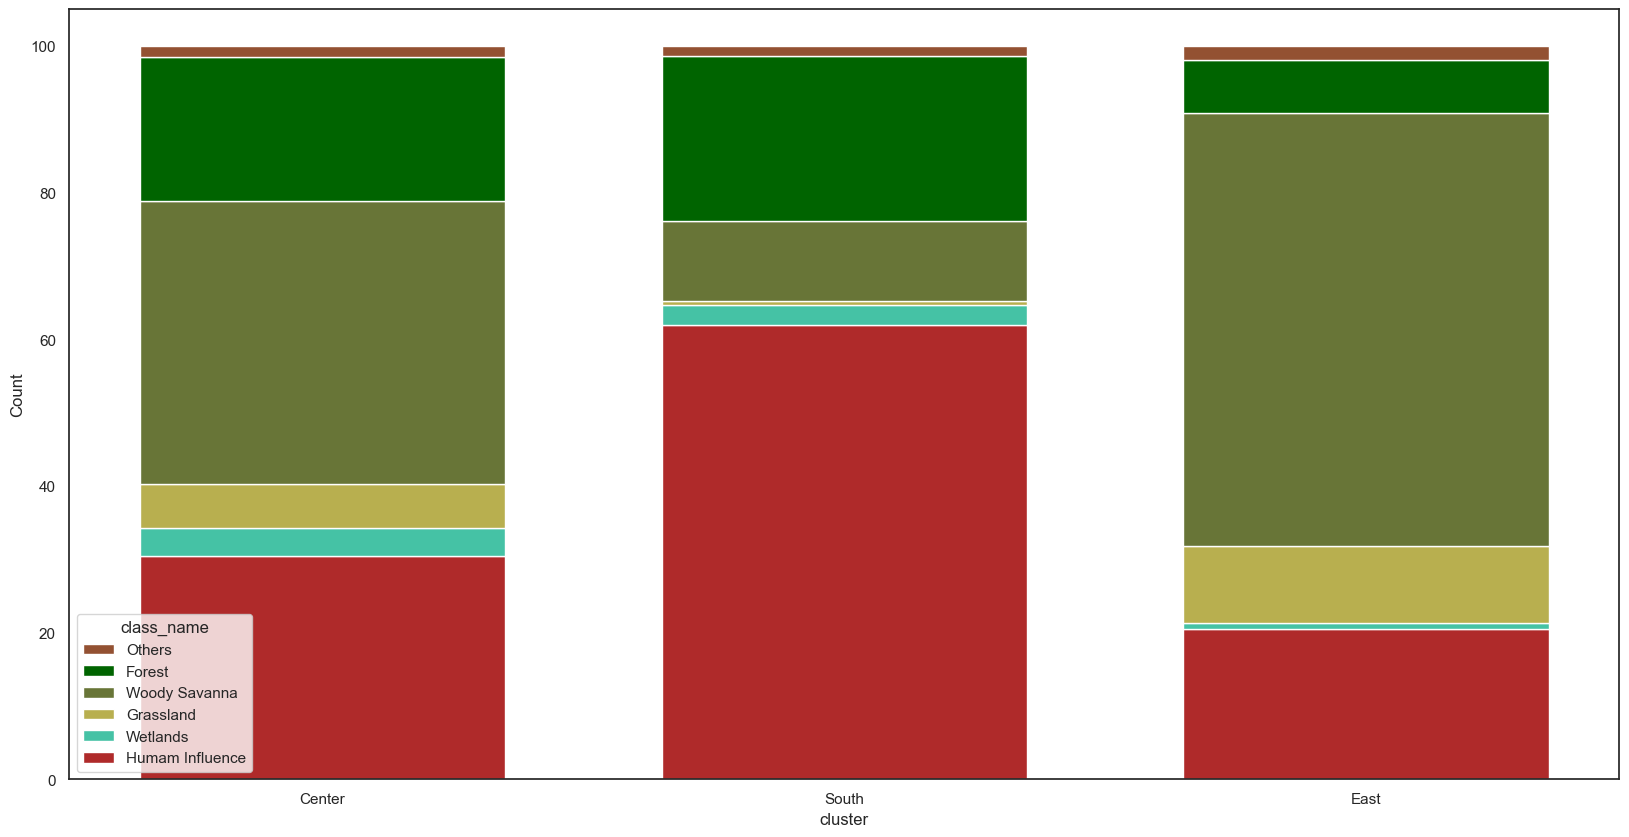

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.set(style="white")
sns.histplot(x="cluster",weights="area_%",hue='class_name',data=dff,multiple='stack',shrink = 0.7, alpha=1,palette=['#935132','#006400', '#687537', '#b8af4f', '#45c2a5', '#af2a2a'])

## MAP mapbiomas

In [3]:
#open mapbiomas for 1985 in cerrado
map10km = xr.open_dataset('Data\Mapbiomas\Regions_10km_test.tif').squeeze()
mapbiomas = pd.read_csv('Data\Mapbiomas\LUC_areas.csv', index_col=0)
map_colors = ['#D5D5E5','#006400', '#6b9932', '#b8af4f', '#45c2a5', '#ea9999']
map1km = xr.open_dataset('Data\Mapbiomas\Regions_1km_test.tif').squeeze()

In [4]:
#define our classes
forest = ['Forest Formation', 'Forest Plantation']
woody_savanna = ['Savanna Formation']
grassland = ['Grassland (Pastizal, Formación Herbácea)']
wetland = ['Wetland', 'Magrove']
humam = ['Pasture','Mining', 'Aquaculture', 'Sugar Cane','Mosaic of Agriculture and Pasture','Urban Infrastructure', 'Soy Beans', 'Rice', 'Mosaic of Crops', 'Coffe', 'Citrus',
       'Other Perennial Crops']
others = ['Beach and Dune', 'Other Non Vegetated Area', 'Rocky outcrop', 'Salt flat', 'River, Lake and Ocean']


In [15]:
#change the data to our classes
aa = map1km.band_data.values
for i, cat in enumerate([forest, woody_savanna, grassland, wetland, humam, others]):
    classes = df.loc[cat].reset_index()['class'].values
    print(classes)
    for j in classes:
        aa[aa==j] = (i+1)*100

#add aa as a dataarray of map10km

map1km['class'] = (('y', 'x'), aa)
#save map10km
#map1km.to_netcdf(r'Data\Mapbiomas\Regions_1km_test_class.nc')

[3. 9.]
[4.]
[12.]
[11.  5.]
[15. 30. 31. 20. 21. 24. 39. 40. 41. 46. 47. 48.]
[ 0. 23. 25. 29. 32. 33.]


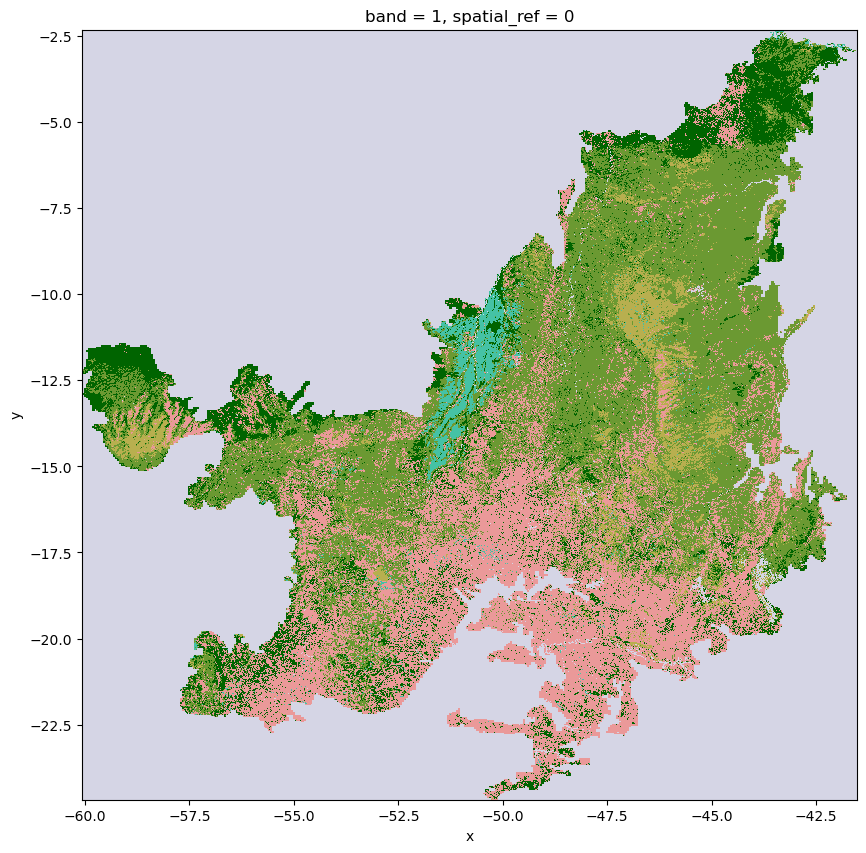

In [16]:
#now plot map10km class with each value as a color
fig, ax = plt.subplots(figsize=(10,10))
map1km['class'].where(map1km['class']>0).plot(ax=ax, colors = ['#006400', '#6b9932', '#b8af4f', '#45c2a5', '#ea9999','#D5D5E5'], levels = [100,200,300,400,500,600,700], add_colorbar = False)




In [17]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from matplotlib.lines import Line2D
regions = gpd.read_file(r'Data\regions1.geojson')
map10km = xr.open_dataset(r'Data\Mapbiomas\Regions_10km_test_class.nc')


<AxesSubplot: title={'center': ' '}, xlabel='x', ylabel='y'>

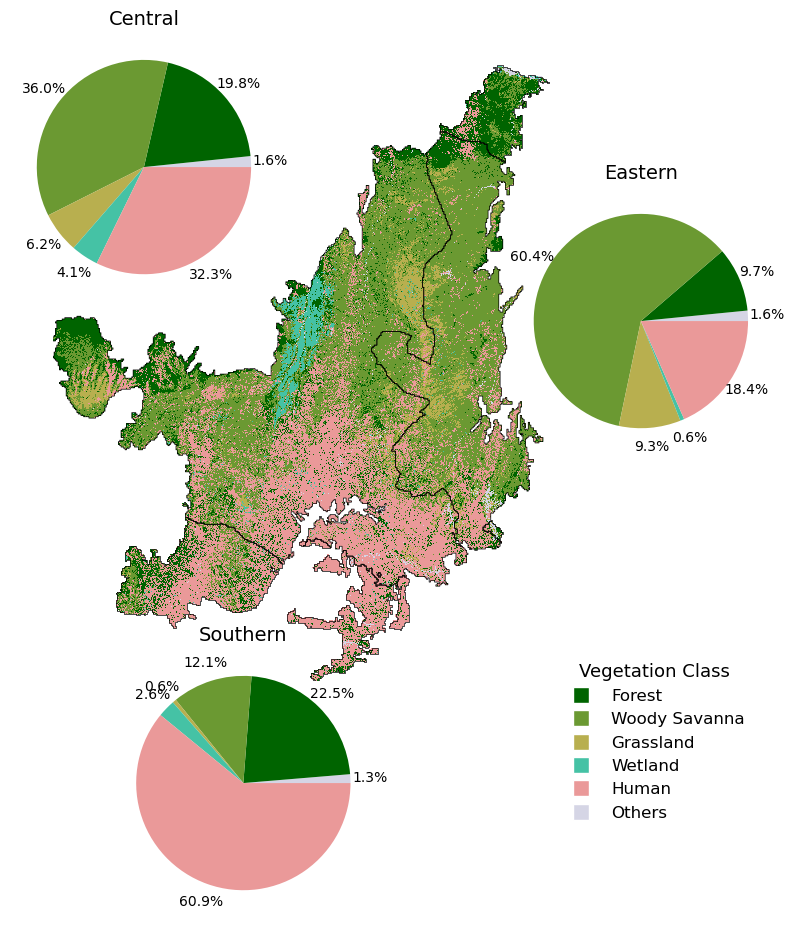

In [ ]:
#now plot map10km class with each value as a color
fig, ax = plt.subplots(figsize=(8,8))
#takeout axis from ax
ax.axis('off')
zoom = 4
#set suptile of ax a blank space
map1km['class'].where(map1km['class']>0).plot(ax=ax, colors = ['#006400', '#6b9932', '#b8af4f', '#45c2a5', '#ea9999','#D5D5E5'], levels = [100,200,300,400,500,600,700], add_colorbar = False)
ax.set_title(' ')


axins = zoomed_inset_axes(ax,zoom,loc='lower left',  bbox_to_anchor=(-0.1,0.6),bbox_transform= ax.transAxes)
axins.pie(mapbiomas['Central'].values,  autopct='%1.1f%%', pctdistance=1.18, colors=map_colors)
axins.set_title('Central', fontsize=14)

axins2 = zoomed_inset_axes(ax,zoom,loc='lower left',  bbox_to_anchor=(0.9,0.35),bbox_transform= ax.transAxes)
axins2.pie(mapbiomas['Eastern'].values,  autopct='%1.1f%%', pctdistance=1.18, colors=map_colors)
axins2.set_title('Eastern', fontsize=14)

axins3 = zoomed_inset_axes(ax,zoom,loc='lower left',  bbox_to_anchor=(0.1,-0.4),bbox_transform= ax.transAxes)
axins3.pie(mapbiomas['Southern'].values,  autopct='%1.1f%%', pctdistance=1.18, colors=map_colors)
axins3.set_title('Southern', fontsize=14)



#ax.annotate('Central', xy=(0.5,0.5), xycoords='axes fraction', xytext=(-0.40,1.05), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", color='black', lw=2, connectionstyle="angle,angleA=0,angleB=90,rad=2"))
#create legend with colorcode
#vreate a legend for the figure, with colors and labels
legend_elements = [Line2D([0], [0],    marker='s', color='w', label='Forest', markerfacecolor=map_colors[1], markersize=12),
                  Line2D([0], [0], marker='s', color='w', label='Woody Savanna', markerfacecolor=map_colors[2], markersize=12),
                  Line2D([0], [0], marker='s', color='w', label='Grassland', markerfacecolor=map_colors[3], markersize=12),
                  Line2D([0], [0], marker='s', color='w', label='Wetland', markerfacecolor=map_colors[4], markersize=12),
                  Line2D([0], [0], marker='s', color='w', label='Human', markerfacecolor=map_colors[5], markersize=12),
                  Line2D([0], [0], marker='s', color='w', label='Others', markerfacecolor=map_colors[0], markersize=12)
]



ax.legend(handles=legend_elements,loc='lower left',  bbox_to_anchor=(1,-0.25),bbox_transform= ax.transAxes, title='Vegetation Class', title_fontsize=13, fontsize=12, frameon=False)


regions.plot(ax=ax, facecolor="none", edgecolor='black', linewidth=0.5)


# VPD

In [ ]:
### create dataset
#path = r"D:\GU\IC\Stations_data\INMET"
#files = glob(os.path.join(path, '*.csv'))
##pd.read_csv(files[0], encoding='latin-1', skiprows=10, delimiter=';', index_col=False,  decimal=',', parse_dates=[0], dayfirst=True)
#li = []
#li2 = []
#for file in files:
#    df = pd.read_csv(file, encoding='latin-1', skiprows=10, delimiter=';', index_col=False,  decimal=',', parse_dates=[0], dayfirst=True)
#    df_info = pd.read_csv(file, encoding='latin-1', delimiter=':', index_col=False,  decimal='.', nrows=5, header=None).set_index(0).T
#    df['Code'] = df_info['Codigo Estacao'].values[0]
#    li.append(df)
#    li2.append(df_info)
#frame = pd.concat(li, axis=0, ignore_index=True)
#frame.drop(columns=['Unnamed: 4', 'Unnamed: 2'], inplace=True)
#frame.rename(columns={'Data Medicao' : 'Date', 'Hora Medicao': 'Hour',  'TEMPERATURA DO AR - BULBO SECO, HORARIA(Â°C)' : 'Temp', 'UMIDADE RELATIVA DO AR, HORARIA(%)':'RH'}, inplace=True)
#frame.to_pickle('Data/inmet_all.pkl')
#
#frame_info = pd.concat(li2, axis=0, ignore_index=True)
#frame_info.rename(columns={'Codigo Estacao' : 'Code', 'Nome Estacao': 'Name'}, inplace=True)
#frame_info.to_csv('Data/inmet_station.csv')   

In [7]:
## load dataset
frame_info = pd.read_csv('Data/inmet_station.csv', index_col=0)
frame = pd.read_pickle('Data/inmet_all.pkl')
frame

,Date,Hour,Temp,RH,Code
0,1981-01-01,0,29.0,79.0,82024
1,1981-01-01,12,NaN,NaN,82024
2,1981-01-01,18,NaN,NaN,82024
3,1981-01-02,0,NaN,NaN,82024
4,1981-01-02,12,NaN,NaN,82024
...,...,...,...,...,...
13100149,2010-12-30,12,22.3,72.0,83997
13100150,2010-12-30,18,25.5,51.0,83997
13100151,2010-12-31,0,20.9,80.0,83997
13100152,2010-12-31,12,24.2,67.0,83997


In [8]:
## create geodataframe
gdf_inmet = gpd.GeoDataFrame(frame_info, geometry=gpd.points_from_xy(frame_info.Longitude, frame_info.Latitude), crs='EPSG:4326')
gdf_ibge_inmet = gpd.sjoin(gdf_inmet.to_crs(ibge.crs), ibge, how='inner', op='intersects')
gdf_ibge_inmet.groupby('biomas').count()
stat_cerrado = gdf_ibge_inmet[gdf_ibge_inmet.biomas == 'CERRADO']
stat_cerrado.drop(columns= ['index_right', 'id', 'objectid', 'shape_leng', 'shape_area'], inplace=True)
stat_cerrado.reset_index(inplace=True, drop=True)


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\luisg\AppData\Local\Temp\ipykernel_21980\410474495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_cerrado.drop(columns= ['index_right', 'id', 'objectid', 'shape_leng', 'shape_area'], inplace=True)


Text(0.5, 1.0, 'INMET Stations in Brazil')

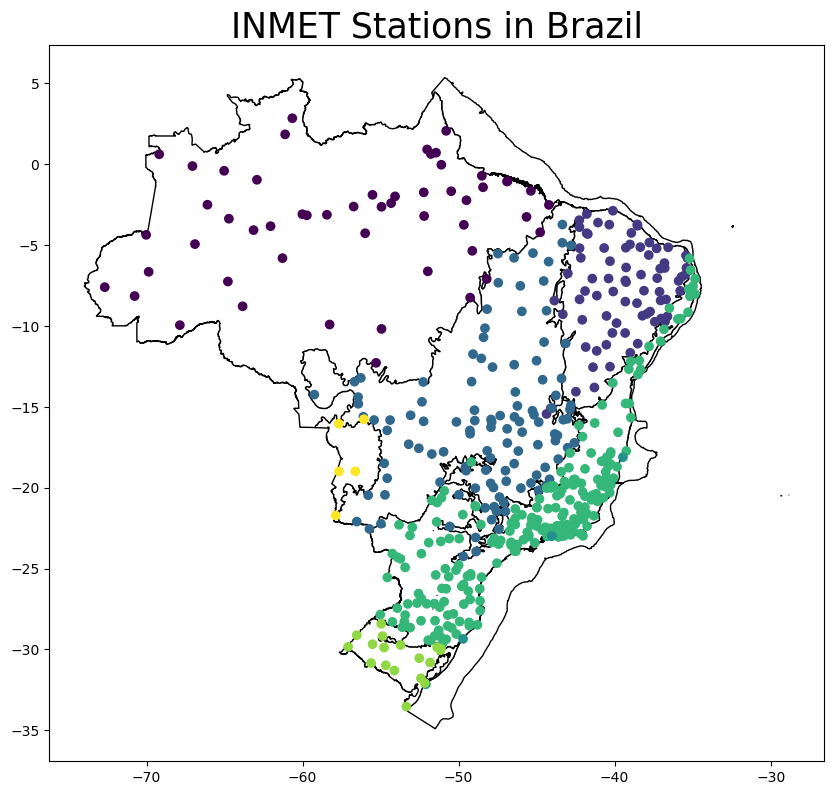

In [9]:
## plot inmet stations by biomes
fig, ax = plt.subplots(figsize=(10,10))
ibge.plot(ax = ax, color='white', edgecolor='black')
gdf_ibge_inmet.plot(ax = ax, column='biomas', cmap='viridis')
#set title
ax.set_title('INMET Stations in Brazil', fontdict={'fontsize': '25', 'fontweight' : '3'})


In [10]:
gdf_ibge_inmet.groupby('biomas').count()

,Nome,Code,Latitude,Longitude,Altitude,geometry,index_right,id,objectid,shape_leng,shape_area
biomas,,,,,,,,,,,
AMAZÔNIA,53,53,53,53,53,53,53,0,53,53,53
CAATINGA,75,75,75,75,75,75,75,0,75,75,75
CERRADO,114,114,114,114,114,114,114,0,114,114,114
MARINHO,4,4,4,4,4,4,4,4,4,4,4
MATA ATLÂNTICA,227,227,227,227,227,227,227,0,227,227,227
PAMPA,18,18,18,18,18,18,18,0,18,18,18
PANTANAL,5,5,5,5,5,5,5,0,5,5,5


In [11]:
# change frame code to integer
frame.Code = frame.Code.astype(int)
inmet_cerrado = frame[frame.Code.isin(stat_cerrado.Code.unique())]
#drop NA
df_rh = inmet_cerrado[~inmet_cerrado['RH'].isna()]
df_rh = df_rh[~df_rh.Temp.isna()]
df_rh = df_rh[df_rh.Temp < 50]
#only stations in cerrado
df_rh_cerrado = df_rh[df_rh.Code.isin(stat_cerrado.Code.unique())]

In [12]:
#how many months of the year appear for each station in df_rh_cerrado
df_months = df_rh_cerrado.groupby([df_rh_cerrado.Date.dt.month,'Code']).size().reset_index().groupby('Code').size().sort_values(ascending=False).reset_index().rename(columns={0:'months'})
#get only code with 12 months
df_months = df_months[df_months.months == 12]
df_rh_cerrado = df_rh_cerrado[df_rh_cerrado.Code.isin(df_months.Code.unique())]

In [13]:
#calculate the monthly mean of daily max and min 
df_day_min = df_rh_cerrado.groupby(['Date', 'Code']).min().reset_index()
df_month_min = df_day_min.groupby([pd.Grouper(freq="M", key='Date'), 'Code']).mean().reset_index().sort_values(['Code','Date'])

df_day_max = df_rh_cerrado.groupby(['Date', 'Code']).max().reset_index()
df_month_max = df_day_max.groupby([pd.Grouper(freq="M", key='Date'), 'Code']).mean().reset_index().sort_values(['Code','Date'])

df_month_min.sort_values(['Code','Date']).reset_index(drop=True, inplace=True)
df_month_max.sort_values(['Code','Date']).reset_index(drop=True, inplace=True)
#merge df_month_min and df_month_max
df_month = pd.merge(df_month_min, df_month_max, on=['Date', 'Code'], suffixes=('_min', '_max')).drop(columns=['Hour_min', 'Hour_max'])

In [14]:
#calculate vpd

def e0(temp):
    return 0.6108 * np.exp((17.27 * temp) / (temp + 237.3)) 

def vpd(temp_max, temp_min, rh_max, rh_min):
    es = (e0(temp_max) + e0(temp_min)) / 2
    ea = (e0(temp_min) * rh_max / 100 + e0(temp_max) * rh_min / 100) / 2
    return es - ea

df_month['VPD'] = vpd(df_month.Temp_max, df_month.Temp_min, df_month.RH_max, df_month.RH_min)	


In [15]:
df_clim = df_month.groupby('Code').mean('Date').reset_index()
gdf_inmet = stat_cerrado.to_crs(regions.crs)
gdf_inmet = gpd.sjoin(gdf_inmet, regions, how='left', op='within')
gdf_inmet_clim = gdf_inmet[['geometry', 'Code', 'region']].merge(df_clim, on='Code') 
gdf_inmet_clim.sort_values('Code', inplace=True)
gdf_inmet_clim['size'] = df_month.Code.value_counts().sort_index().reset_index()['Code']
gdf_inmet_clim = gdf_inmet_clim[gdf_inmet_clim['size'] > 180].reset_index(drop=True)


c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [16]:
#save gdf_inmet_clim and df_month
#gdf_inmet_clim.to_file(r'Data\Inmet\gdf_inmet_clim.geojson', driver='GeoJSON')
#df_month.to_csv(r'Data\Inmet\df_INMET_monthly.csv', index=False)

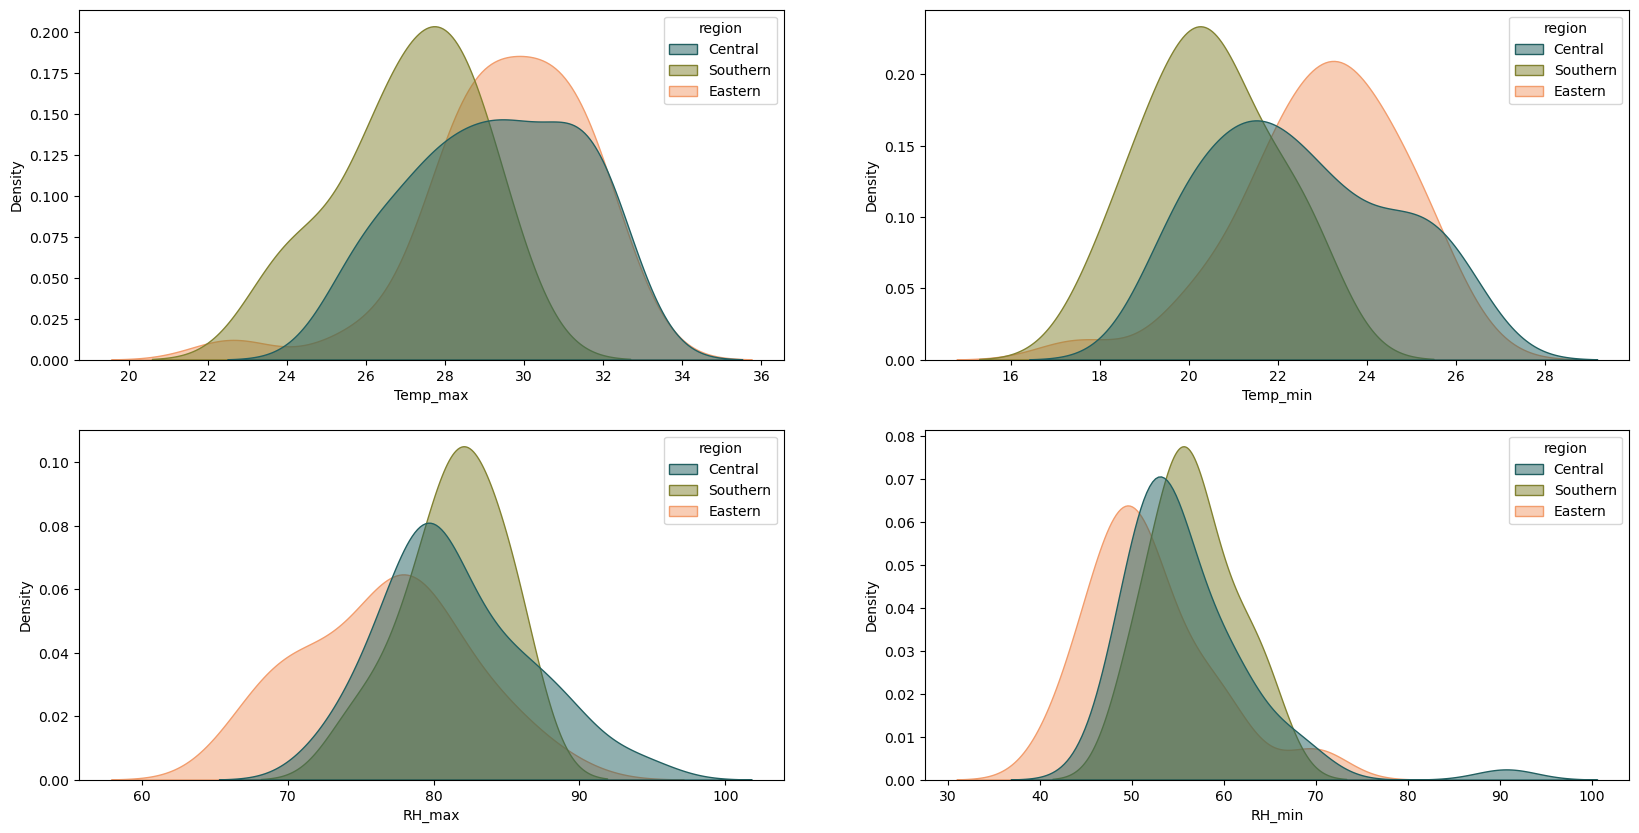

In [18]:
#plot a kde for all metrics in gdf_inmet_clim
fig, axes = plt.subplots(2, 2, figsize=(20,10))
for i, metric in enumerate(['Temp_max', 'Temp_min', 'RH_max', 'RH_min']):
    sns.kdeplot(x=metric, hue='region', data=gdf_inmet_clim, ax=axes[i//2][i%2], fill=True, common_norm=False,
                alpha=.5, linewidth=1, palette=palette,hue_order=['Central','Southern', 'Eastern'])
    axes[i//2][i%2].set_xlabel(metric)